# Homework 2. Text representation 

## Homework description

**Theory** (6 points):

>Read Explore comments. Follow links.  
>Answer theory questions in the Google Form.

**Practice** (9 points):

Take into account all **TODO** left by us in code. They might give you good insights.
        
> For the [CommonLit - Evaluate Student Summaries](https://www.kaggle.com/competitions/commonlit-evaluate-student-summaries/) task and dataset aim to improve compettion score both on validation and leaderboard. Try the following:
> - improve data processing (text proccessing techniques), feature selection;
> - tweak vectorization, use both Bag Of Words, TF-IDF (hint: read docs to modify their parameters) and Sentence embeddings (word2vec, SpaCy, BERT Sentence Transformers, etc);
> - changing model hyperparameters, adding regularization


> *Advanced*: Take a look at **TODO** one more time. Maybe you can improve our notebook.




## Setup

In [156]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import gensim
import nltk
import spacy
import sentence_transformers
import re
import spacy
import matplotlib.pyplot as plt

In [154]:
import lightgbm
import optuna

/home/evgeniy/.local/lib/python3.9/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/home/evgeniy/.local/lib/python3.9/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/home/evgeniy/.local/lib/python3.9/site-packages/dask/dataframe/utils.py:367: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


In [219]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
from sklearn.metrics.pairwise import cosine_similarity

## 1. Business Understanding

The project aims to develop a model for evaluating the quality of summaries written by students in grades 3-12. Summary writing is a crucial skill that enhances reading comprehension, especially for second language learners and students with learning disabilities. It promotes critical thinking and serves as an effective means to improve writing abilities. The main focus of the project is on assessing how well a student represents the main idea and details of a given source text, alongside evaluating the clarity, precision, and fluency of the language used in the summary. 

The primary beneficiaries of the project are teachers and students. Teachers will benefit from a time-efficient tool that facilitates quick and effective evaluation of student summaries. Students can use this tool to receive immediate feedback on their work, thus producing more dynamic learning process. 

## 2. Data Understanding

In [13]:
os.listdir("../data/commonlit-evaluate-student-summaries/")

['summaries_train.csv',
 'sample_submission.csv',
 'prompts_test.csv',
 'prompts_train.csv',
 'summaries_test.csv']

In [14]:
dir = "../data/"
# dir = "/kaggle/input/"
prompts_train = pd.read_csv(os.path.join(dir, "commonlit-evaluate-student-summaries/prompts_train.csv"))
summaries_train = pd.read_csv(os.path.join(dir, "commonlit-evaluate-student-summaries/summaries_train.csv"))

prompts_test = pd.read_csv(os.path.join(dir, "commonlit-evaluate-student-summaries/prompts_test.csv"))
summaries_test = pd.read_csv(os.path.join(dir, "commonlit-evaluate-student-summaries/summaries_test.csv"))

sample_submission = pd.read_csv(os.path.join(dir, "commonlit-evaluate-student-summaries/sample_submission.csv"))

### Dataset structure

The task falls into the category of **supervised learning** since target scores are provided for the training dataset. 

The provided dataset consists of two parts: **prompts**, i.e. summarization tasks, given to students, and actual **students' summaries**. Train part of those summaries also contains the assigned score. 

**Summaries in the training set**
- `student_id` - The ID of the student writer.
- `prompt_id` - The ID of the prompt which links to the prompt file.
- `text` - The full text of the student's summary.
- `content` - The content score for the summary. The first target.
- `wording` - The wording score for the summary. The second target.

**The four training set prompts. Each prompt comprises the complete summarization assignment given to students.**
- `prompt_id` - The ID of the prompt which links to the summaries file.
- `prompt_question` - The specific question the students are asked to respond to.
- `prompt_title` - A short-hand title for the prompt.
- `prompt_text` - The full prompt text.

In [21]:
prompts_train

,prompt_id,prompt_question,prompt_title,prompt_text
0,39c16e,Summarize at least 3 elements of an ideal trag...,On Tragedy,Chapter 13 \r\nAs the sequel to what has alrea...
1,3b9047,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...
2,814d6b,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...
3,ebad26,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an..."


In [5]:
prompts_train.shape, summaries_train.shape

((4, 4), (7165, 5))

In [6]:
prompts_test.shape, summaries_test.shape

((2, 4), (4, 3))

In [8]:
print(prompts_train.loc[0, 'prompt_title'])
print(prompts_train.loc[0, 'prompt_question'])
print(prompts_train.loc[0, 'prompt_text'])

On Tragedy
Summarize at least 3 elements of an ideal tragedy, as described by Aristotle.
Chapter 13 
As the sequel to what has already been said, we must proceed to consider what the poet should aim at, and what he should avoid, in constructing his plots; and by what means the specific effect of Tragedy will be produced. 
A perfect tragedy should, as we have seen, be arranged not on the simple but on the complex plan. It should, moreover, imitate actions which excite pity and fear, this being the distinctive mark of tragic imitation. It follows plainly, in the first place, that the change of fortune presented must not be the spectacle of a virtuous man brought from prosperity to adversity: for this moves neither pity nor fear; it merely shocks us. Nor, again, that of a bad man passing from adversity to prosperity: for nothing can be more alien to the spirit of Tragedy; it possesses no single tragic quality; it neither satisfies the moral sense nor calls forth pity or fear. Nor, again, 

In [9]:
summaries_train.head()

,student_id,prompt_id,text,content,wording
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757


In [10]:
summaries_train.isna().any()

student_id    False
prompt_id     False
text          False
content       False
wording       False
dtype: bool

### Target values

The target, i.e. the score of the student's summary, consists of two parts: *wording score* and *content score*. Those scores are provided for the train part. Although there is no explicit description what criteries were used for those scores during the evaluation, it can be assumed that the *content score* should represent how well the summary summarizes the proposed text, while the *wording score* evaluates the summary from the writing perspective. An important consequence from this assumption is that the *wording score* doesn't depend on the prompt question content.  

### Evaluation Metric

The performance of the model will be estimated based on the mean columnwise RMSE:

$$MCRMSE = \frac{1}{N_t} \sum\limits_{j=1}^{N_t} \left(\frac1n \sum\limits_{i=1}^n (y_{ij} - \hat{y}_ij)\right)^2$$

In our case there are two target values, i.e. $N_t = 2$. Since the number of independent RMSEs is fixed, minimization of the MCRMSE is equivalent to the separate minimization of RMSE for each target value. This means that the models for *writing* and *content* score can be trained and optimized separately based on the RMSE.

## 3. Data Preparation and EDA

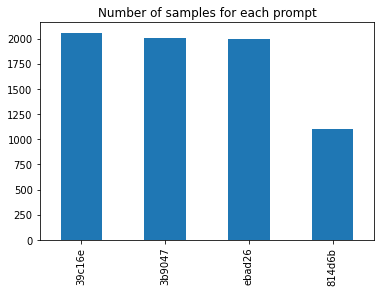

In [70]:
summaries_train['prompt_id'].value_counts().plot(kind='bar')
plt.title("Number of samples for each prompt")
plt.show()

### Target distribution

Let's take a look at the distributions of the target scores

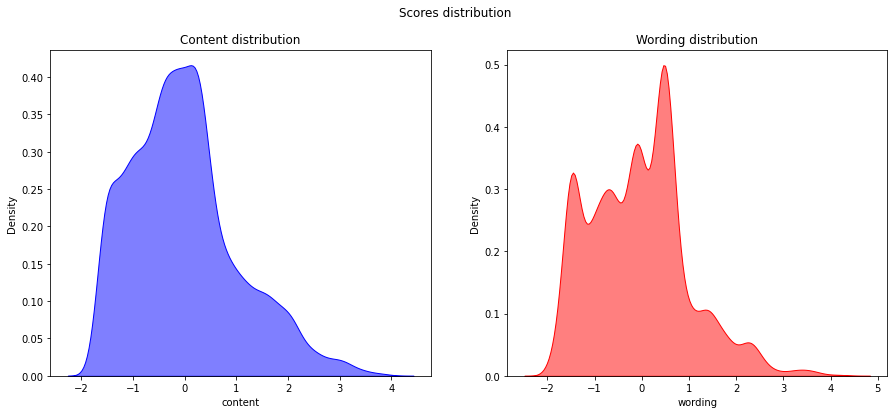

In [23]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

axs[0].set_title("Content distribution")
axs[1].set_title("Wording distribution")
sns.kdeplot(data=summaries_train, x="content",color="b", alpha=.5, fill=True, ax=axs[0])
sns.kdeplot(data=summaries_train, x="wording",color="r", alpha=.5, fill=True, ax=axs[1])

plt.suptitle("Scores distribution")
plt.show()

From the plots we can assume that possible range for both scores is (-3, 5). The *content* is distributed more smoothly.

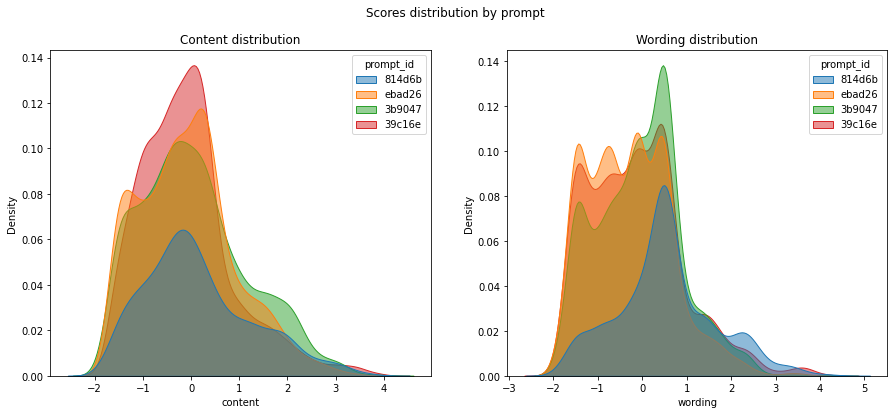

In [59]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

axs[0].set_title("Content distribution")
axs[1].set_title("Wording distribution")
sns.kdeplot(data=summaries_train, x="content",color="b", alpha=.5, fill=True, ax=axs[0], hue='prompt_id')
sns.kdeplot(data=summaries_train, x="wording",color="r", alpha=.5, fill=True, ax=axs[1], hue='prompt_id')

plt.suptitle("Scores distribution by prompt")
plt.show()

Prompt `814d6b` has less samples than 3 others, yet distributions of target scores for each prompt more or less similiar.

### Text preprocessing

We are going to have different preprocessings for wording and content evaluations. For content score the main focus should be on the meaning of texts, so it seems a good idea to remove stopwords and execute lemmatization. For wording evaluation we remain the stopwords, so that for example a summary can be punished for using too many simple auxiliary words.

In [141]:
def preprocess_general(text):
    tokens = nltk.tokenize.word_tokenize(text)
    tokens = [t.lower() for t in tokens]
    tokens = [t for t in tokens if t.isalpha()]
    return " ".join(tokens)

In [151]:
nltk.download("wordnet")
nltk.download("omw-1.4")

stop_words = set(nltk.corpus.stopwords.words("english"))
lemmatizer = nltk.stem.WordNetLemmatizer()

def remove_stopwords_and_lemmatize(text):
    filtered = []
    for word in nltk.tokenize.word_tokenize(text):
        if word.lower() not in stop_words: 
            filtered.append(lemmatizer.lemmatize(word))
    return " ".join(filtered)


[nltk_data] Downloading package wordnet to /home/evgeniy/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/evgeniy/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [152]:
summaries_train['cleaned_text'] = summaries_train['text'].apply(preprocess_general)
summaries_train['xcleaned_text'] = summaries_train['cleaned_text'].apply(remove_stopwords_and_lemmatize)

In [153]:
prompts_train['cleaned_prompt_text'] = prompts_train['prompt_text'].apply(lambda x: remove_stopwords_and_lemmatize(preprocess_general(x)))

### Sentence embdeddings

Let's see if we can utilize sentence embedings to improve content scorer

In [159]:
sbert_model = sentence_transformers.SentenceTransformer('all-MiniLM-L6-v2')

In [166]:
sbert_model.parameters

<bound method Module.parameters of SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 384, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
  (2): Normalize()
)>

In [170]:
prompts_embeddings = sbert_model.encode(prompts_train['cleaned_prompt_text'])

In [171]:
summaries_embeddings = sbert_model.encode(summaries_train['xcleaned_text'])

In [174]:
prompts_embeddings.shape, summaries_embeddings.shape

((4, 384), (7165, 384))

In [177]:
(prompts_embeddings @ summaries_embeddings.T).shape

(4, 7165)

In [233]:
def similarity(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [235]:
prompt_idx_mapper = dict(zip(prompts_train['prompt_id'].to_list(), prompts_train.index))
summaries_train['prompt_idx'] = summaries_train['prompt_id'].map(prompt_idx_mapper)
summaries_train['summary_idx'] = summaries_train.index
summaries_train['similarity_to_prompt'] = \
    summaries_train.apply(lambda x: similarity(prompts_embeddings[x['prompt_idx']], summaries_embeddings[x['summary_idx']]), axis=1)
summaries_train = summaries_train.drop(columns=['prompt_idx', 'summary_idx'])

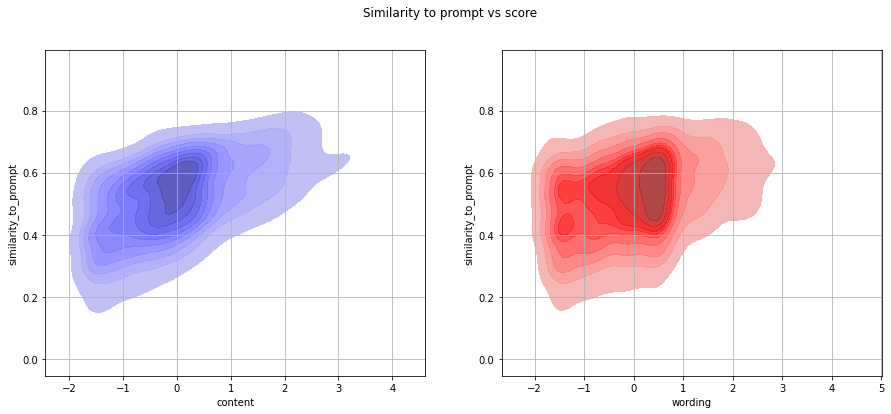

In [241]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

sns.kdeplot(data=summaries_train, x='content', y='similarity_to_prompt', color='b', fill=True, alpha=0.9, ax=axs[0])
sns.kdeplot(data=summaries_train, x='wording', y='similarity_to_prompt', color='r', fill=True, alpha=0.9, ax=axs[1])

axs[0].grid()
axs[1].grid()

plt.suptitle("Similarity to prompt vs score")
plt.show()

Expectedly, there is some correlation between content score and similarity to prompt. Some similarity of distribution shape for the same comparison with wording can be explained by correlation between content and wording scores (in general, we expect wording evaluation to be independent from prompt)

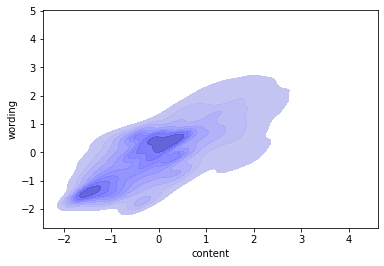

In [243]:
sns.kdeplot(data=summaries_train, x='content', y='wording', color='b', fill=True, alpha=0.9)
plt.show()

### Words vectorization

For wording we will try to use additionally Bag of Words and TF-IDF vectorizations

### Additional features

During the text preprocessing we may have lost some information, as punctuation, number of sentences etc. Let's compute some of such featurs and see how they correlate with scores

In [258]:
summaries_train['n_words'] = summaries_train['cleaned_text'].apply(lambda x: len(x.split(" ")))
summaries_train['n_sentences'] = summaries_train['text'].str.count('\.')
summaries_train['mean_word_length'] = summaries_train['cleaned_text'].apply(lambda x: np.mean([len(word) for word in x.split()]))
summaries_train['n_punctuation'] = summaries_train.apply(lambda x: len(x['text']) - len(x['cleaned_text']), axis=1)

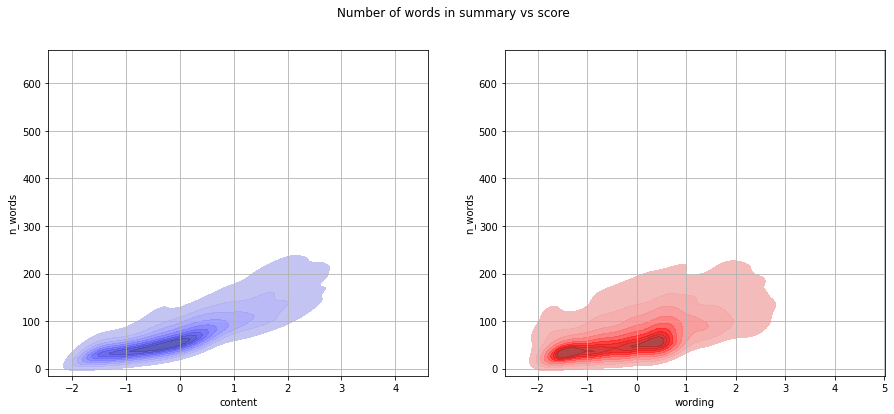

In [260]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

sns.kdeplot(data=summaries_train, x='content', y='n_words', color='b', fill=True, alpha=0.9, ax=axs[0])
sns.kdeplot(data=summaries_train, x='wording', y='n_words', color='r', fill=True, alpha=0.9, ax=axs[1])

axs[0].grid()
axs[1].grid()

plt.suptitle("Number of words in summary vs score")
plt.show()

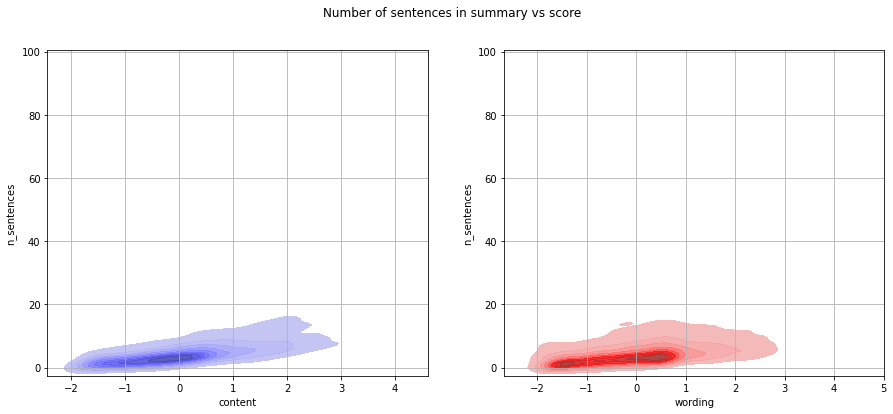

In [261]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

sns.kdeplot(data=summaries_train, x='content', y='n_sentences', color='b', fill=True, alpha=0.9, ax=axs[0])
sns.kdeplot(data=summaries_train, x='wording', y='n_sentences', color='r', fill=True, alpha=0.9, ax=axs[1])

axs[0].grid()
axs[1].grid()

plt.suptitle("Number of sentences in summary vs score")
plt.show()

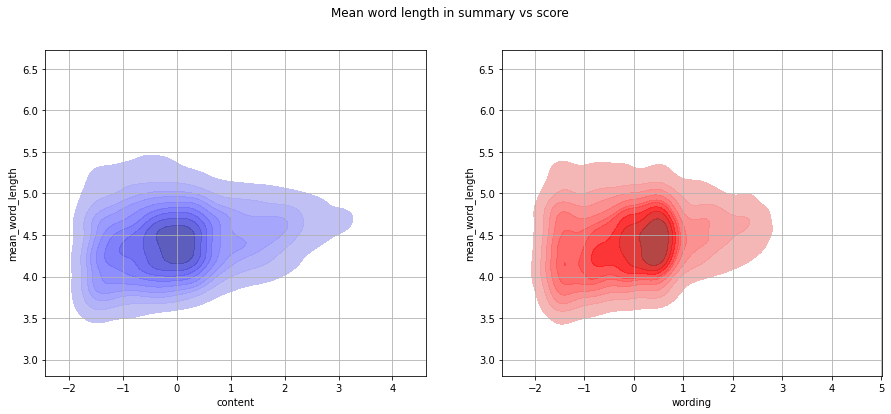

In [262]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

sns.kdeplot(data=summaries_train, x='content', y='mean_word_length', color='b', fill=True, alpha=0.9, ax=axs[0])
sns.kdeplot(data=summaries_train, x='wording', y='mean_word_length', color='r', fill=True, alpha=0.9, ax=axs[1])

axs[0].grid()
axs[1].grid()

plt.suptitle("Mean word length in summary vs score")
plt.show()

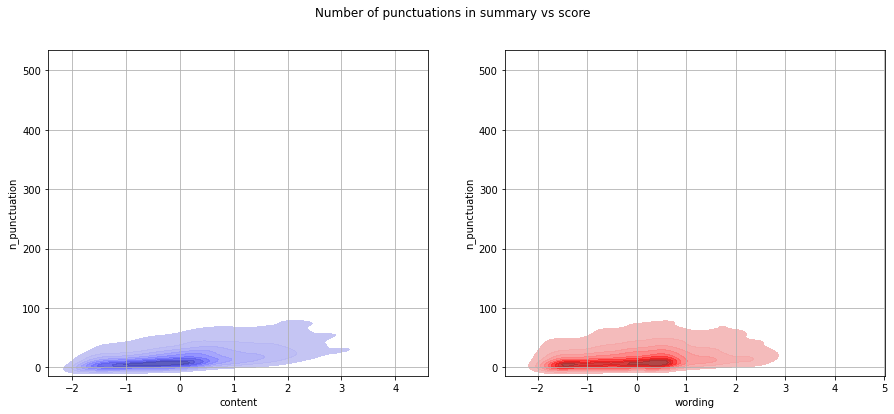

In [263]:
fig, axs = plt.subplots(1, 2, figsize=(15, 6))

sns.kdeplot(data=summaries_train, x='content', y='n_punctuation', color='b', fill=True, alpha=0.9, ax=axs[0])
sns.kdeplot(data=summaries_train, x='wording', y='n_punctuation', color='r', fill=True, alpha=0.9, ax=axs[1])

axs[0].grid()
axs[1].grid()

plt.suptitle("Number of punctuations in summary vs score")
plt.show()

## 4. Modeling 

Since the scores depend on both summary and prompt, it's important that train and test sets don't have samples with common prompts. Taking this into account, we can construct test set by takig out all samples for one of the four prompts and leave all other for train.

In [32]:
df['prompt_id'].unique()

array(['814d6b', 'ebad26', '3b9047', '39c16e'], dtype=object)

In [44]:
df_train = df[df['prompt_id'] != '814d6b']
df_test = df[df['prompt_id'] == '814d6b']

### Baseline model

## 5. Evaluation

## Possible improvements 

1. It would be good to verify the guess of influence of stopwords on the wording score via training the model on both cleaned and uncleaned texts